In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import cv2
import keras
 
from tensorflow.keras.layers import BatchNormalization

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [3]:
eczema_dir='/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677'
Melanoma_dir='/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/2. Melanoma 15.75k'
atopic='/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/3. Atopic Dermatitis - 1.25k'
bcc_dir='/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/4. Basal Cell Carcinoma (BCC) 3323'
melanocytic='/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/5. Melanocytic Nevi (NV) - 7970'
benign='/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624'

In [4]:
class_labels = ['Atopic Dermatitis','Basal Cell Carcinoma','Benign Keratosis-like Lesions','Eczema','Melanocytic Nevi','Melanoma']

In [5]:
image_paths = []
labels = []

# create an empty dictionary to store the class label to subfolder name mappings
class_label_map = {}
dir_list=[atopic,bcc_dir,benign,eczema_dir,melanocytic,Melanoma_dir]
for i, j in enumerate(dir_list):
    class_label_map[i] = class_labels[i]
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        image_paths.append(fpath)
        labels.append(class_labels[i])
data = {"image_path": image_paths, "class_label": labels}
df = pd.DataFrame(data)  

In [6]:
num_class=df['class_label'].nunique()

# Balancing the classes
I have manually selected the classes for the dataset. To balance the number of images across classes, any class containing more than 2000 images is reduced to 2000 images. This threshold of 2000 was chosen because it reflects the typical count for most classes, ensuring a more uniform dataset that facilitates improved model training and evaluation.

In [7]:
reduced_class_dfs = []  
for l in class_labels:
    # Get all images for the current class
    class_df = df[df['class_label'] == l]
    
    # If the class has more than 2000 images, sample 2000 images
    if len(class_df) > 2000:
        class_df = class_df.sample(n=2000, random_state=42)
    
    # Add the dataframe to the list, including classes with 2000 or fewer images
    reduced_class_dfs.append(class_df)

# Concatenate all the dataframes into one balanced dataframe
balanced_df = pd.concat(reduced_class_dfs)

# Shuffle the dataframe to mix the images
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(len(balanced_df))


10934


In [8]:
train_df, remaining_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['class_label'], random_state=42)

# Splitting the remaining dataset into validation (10%) and test (10%)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['class_label'], random_state=42)

# Print the number of samples in each class for each set
print('Training set:\n', train_df['class_label'].value_counts())
print('Validation set:\n', val_df['class_label'].value_counts())
print('Test set:\n', test_df['class_label'].value_counts())

Training set:
 class_label
Melanocytic Nevi                 1600
Melanoma                         1600
Basal Cell Carcinoma             1600
Benign Keratosis-like Lesions    1600
Eczema                           1341
Atopic Dermatitis                1006
Name: count, dtype: int64
Validation set:
 class_label
Melanocytic Nevi                 200
Basal Cell Carcinoma             200
Melanoma                         200
Benign Keratosis-like Lesions    200
Eczema                           168
Atopic Dermatitis                125
Name: count, dtype: int64
Test set:
 class_label
Melanocytic Nevi                 200
Basal Cell Carcinoma             200
Benign Keratosis-like Lesions    200
Melanoma                         200
Eczema                           168
Atopic Dermatitis                126
Name: count, dtype: int64


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224,224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        #filtered_image = cv2.medianBlur(img, 3)
        # Convert to grayscale
        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #gray = gray.astype(np.uint8)
        #equalized = cv2.equalizeHist(gray)
        # Thresholding to create a mask
        #clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(5,5))
        #equalized = clahe.apply(gray)
        #_, mask = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Invert the mask
        #mask_inv = cv2.bitwise_not(mask)
        # Create a black background image
       # background = np.zeros_like(img)

        # Use the mask to extract the non-disease area and combine it with the black background
        #non_disease_area = cv2.bitwise_and(img, img, mask=mask_inv)
        #segmented_image = cv2.add(non_disease_area, background)

        # Resize the image to the desired size (e.g., 256x256)
        b, g, r = cv2.split(img)

    # Create CLAHE object
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(5, 5))

    # Apply CLAHE to each channel
        r = clahe.apply(r.astype(np.uint8))
        g = clahe.apply(g.astype(np.uint8))
        b = clahe.apply(b.astype(np.uint8))

    # Merge the enhanced channels back
        enhanced_img = cv2.merge((b, g, r))
        
        # Resize the image to the desired size (e.g., 256x256)
        resized_image = cv2.resize(enhanced_img, img_size)
       
        #resized_image = cv2.resize(resized_image, img_size)
        resized_image = resized_image.astype('float32') / 255.0 
        
        
        return resized_image
        

    

    train_image_gen = ImageDataGenerator(preprocessing_function= scalar, 
                                rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                               
                                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                shear_range=0.2, 
                                 fill_mode='nearest' # Shear angle in counter-clockwise direction in degrees
                                )
    test_gen=ImageDataGenerator(preprocessing_function= scalar)
    train = train_image_gen.flow_from_dataframe(dataframe= train_df,x_col="image_path",y_col="class_label",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=True            #do not shuffle data
                                     )

    val = train_image_gen.flow_from_dataframe(dataframe= val_df,x_col="image_path", y_col="class_label",
                                    target_size=(224,224),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=True
                                   )
    test = test_gen.flow_from_dataframe(dataframe= test_df,x_col="image_path", y_col="class_label",
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )

    return train, val, test


try:

    # Get Generators
    batch_size = 32
    train, val, test = create_gens(train_df, val_df,test_df, batch_size)

except:
    print('Invalid Input')

Found 8747 validated image filenames belonging to 6 classes.
Found 1093 validated image filenames belonging to 6 classes.
Found 1094 validated image filenames belonging to 6 classes.


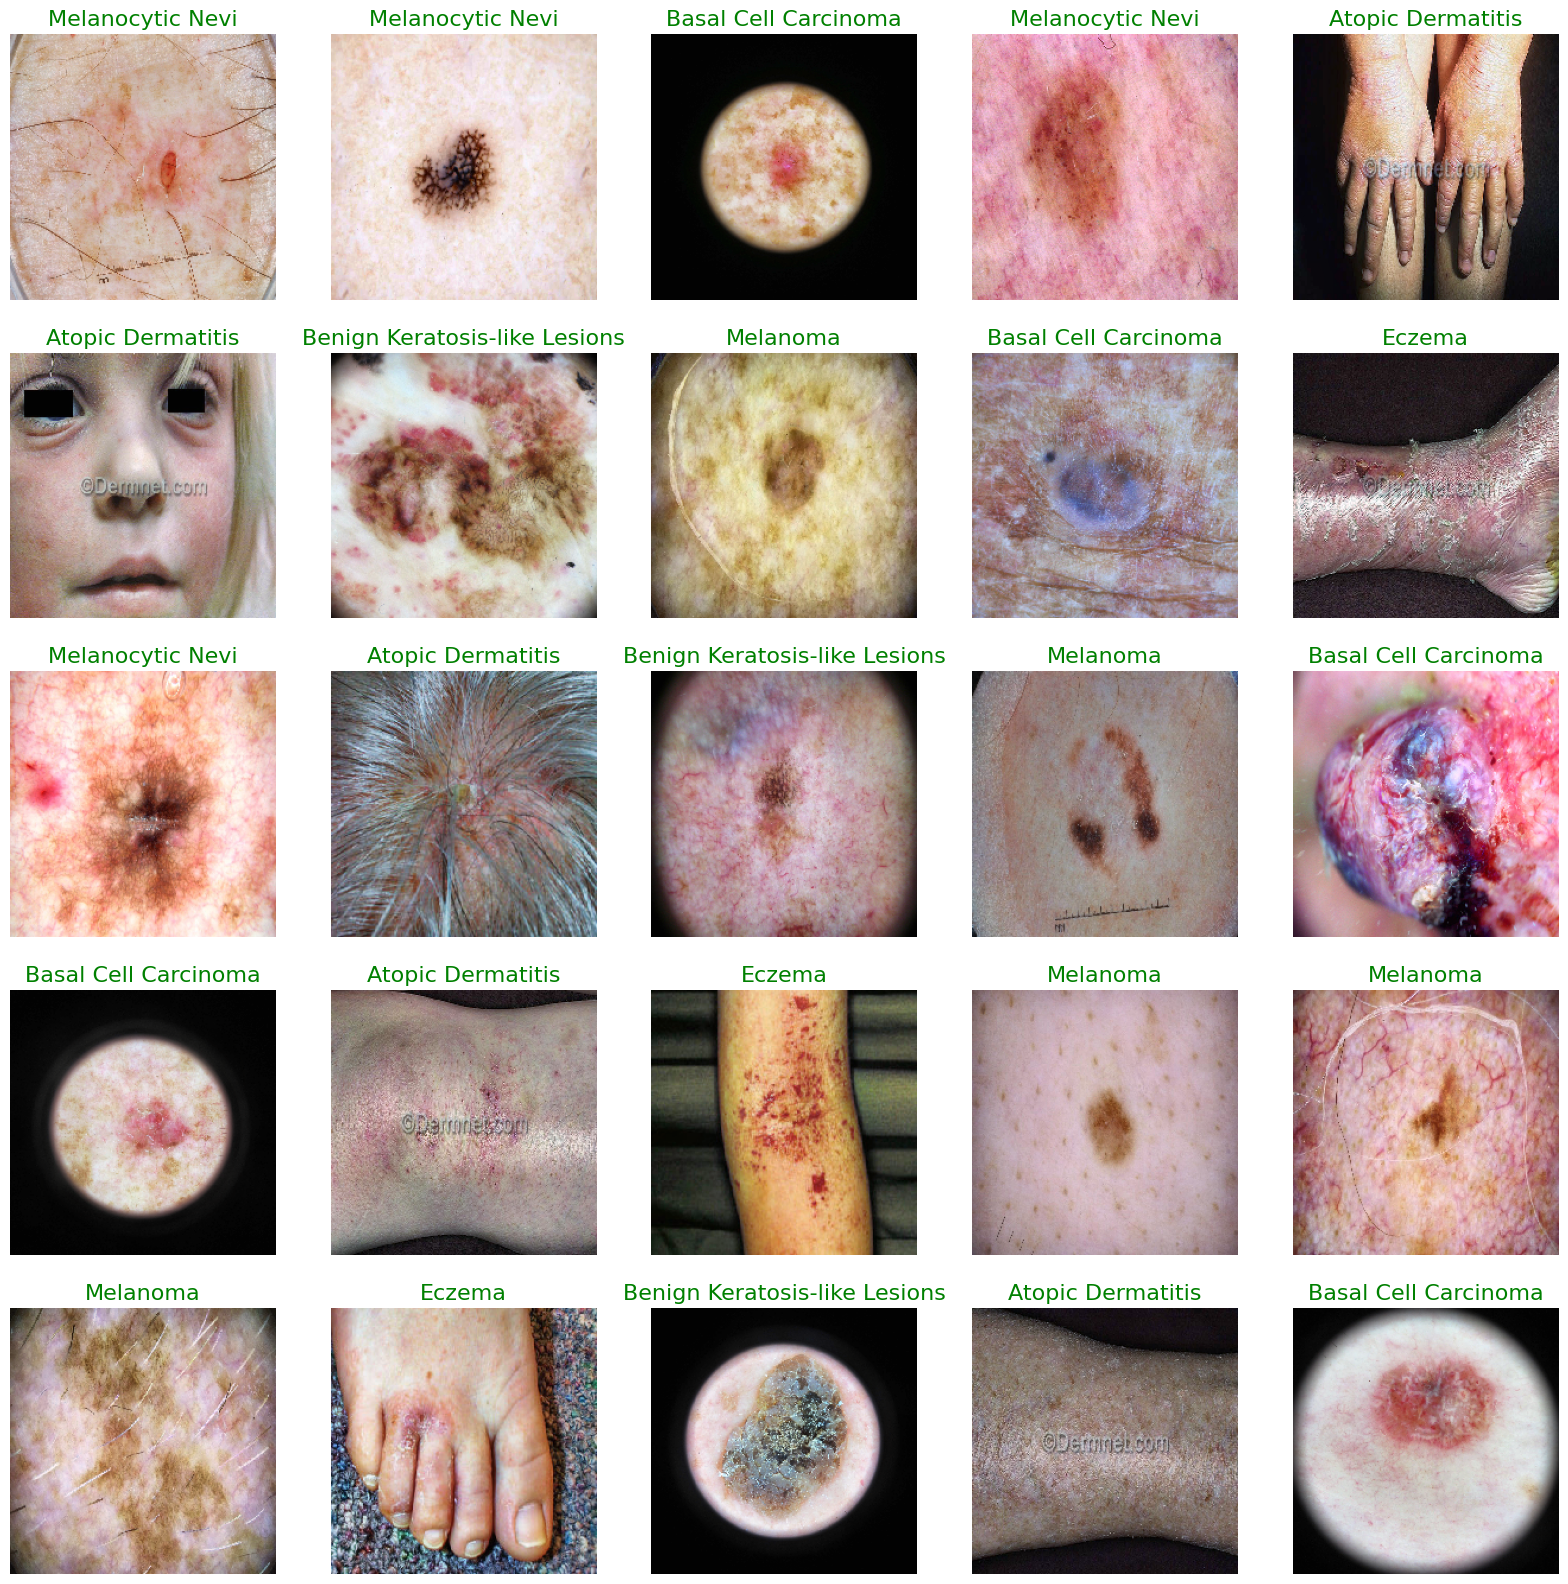

In [10]:


def show_Skin_images(image_gen):
    test_dict = train.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        #image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(images[i])
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_Skin_images(test)



In [11]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,ReLU,GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization,Dropout,Embedding,Activation,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception

In [13]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import UpSampling2D
from keras.layers import Input, Conv2D, MaxPooling2D, Multiply,Flatten, Dense, Activation, BatchNormalization, Reshape, Bidirectional, LSTM, Dropout
from keras import regularizers
def channel_attention(input_tensor, reduction_ratio=16):
    num_channels = input_tensor.shape[-1]
    l1=tf.keras.layers.Dense(num_channels//reduction_ratio,activation='relu',use_bias=False)
    l2=tf.keras.layers.Dense(num_channels,use_bias=False)
    
    x1=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    x1=l1(x1)
    x1=l2(x1)
    
    x2=tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
    x2=l1(x2)
    x2=l2(x2)
    
    feats=x1+x2
    feats=Activation("sigmoid")(feats)
    feats=Multiply()([input_tensor,feats])
    
    return feats
def spatial_attention(input_tensor):
    kernel_size = 7
    
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_tensor)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_tensor)
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    
    out = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal')(concat)

    return layers.Multiply()([input_tensor, out])

    

def cbam_block(input_tensor, reduction_ratio=16):
    channel_att = channel_attention(input_tensor, reduction_ratio)
    spatial_att = spatial_attention(channel_att)
    
    return spatial_att
def build_model(num_classes):
    # Input layer
    input_layer = keras.layers.Input(shape=(224,224, 3))

    # Load DenseNet121 as the base model without the top classification layer
    mNet=Xception(include_top=False, weights='imagenet', input_tensor=input_layer)
    
    for layer in mNet.layers:
        layer.trainable=True
    x=cbam_block(mNet.output)

    # Add custom layers on top
    x = keras.layers.GlobalAveragePooling2D()(x)           # Flatten the DenseNet output
    x = Dense(512, activation='relu')(x)     # First fully connected layer
    x = Dropout(0.5)(x)                      # Dropout for regularization
    x = Dense(256, activation='relu')(x)     # Second fully connected layer
    x = Dropout(0.5)(x)                      # Dropout for regularization
    output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    

    return model
model = build_model(6)
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,567,825 (86.09 MB)

 Trainable params: 22,513,297 (85.88 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [14]:
import tensorflow as tf
METRICS=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [15]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=METRICS)

In [16]:


history=model.fit(train, epochs=30, batch_size=32,  validation_data = (val))

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727768277.165839      70 service.cc:145] XLA service 0x796fc4001fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727768277.165893      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727768306.389898      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 ━━━━━━━━━━━━━━━━━━━━ 329s 990ms/step - accuracy: 0.4713 - loss: 1.2783 - precision: 0.6761 - recall: 0.2557 - val_accuracy: 0.8060 - val_loss: 0.4777 - val_precision: 0.8175 - val_recall: 0.7951
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 208s 686ms/step - accuracy: 0.8391 - loss: 0.4318 - precision: 0.8536 - recall: 0.8155 - val_accuracy: 0.8381 - val_loss: 0.4108 - val_precision: 0.8497 - val_recall: 0.8326
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 191s 683ms/step - accuracy: 0.8949 - loss: 0.2935 - precision: 0.9054 - recall: 0.8821 - val_accuracy: 0.8564 - val_loss: 0.4004 - val_precision: 0.8611 - val_recall: 0.8509
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 193s 687ms/step - accuracy: 0.9239 - loss: 0.2190 - precision: 0.9313 - recall: 0.9188 - val_accuracy: 0.8701 - val_loss: 0.3862 - val_precision: 0.8763 - val_recall: 0.8618
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 193s 688ms/step - accuracy: 0.9438 - loss: 0.1755 - precision: 0.9474 - recall: 0.9399 - val_accuracy: 0.8683 - val

In [17]:
test_auc,test_loss,test_precision,test_recall=model.evaluate(test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 535ms/step - accuracy: 0.8885 - loss: 0.5817 - precision: 0.8894 - recall: 0.8881


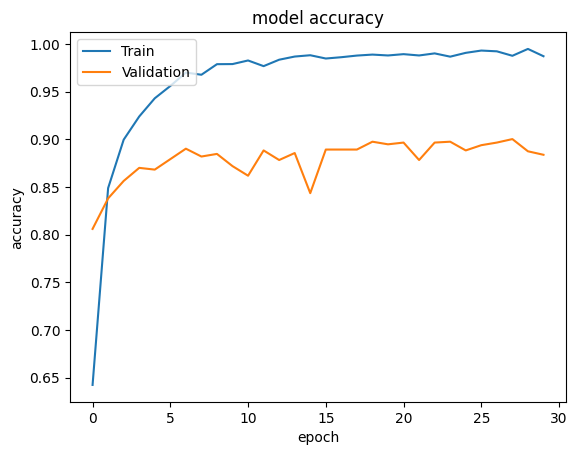

In [18]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save model

In [19]:
from tensorflow.keras.models import save_model
save_model(model, "/kaggle/working/Xception_Net_model_4.h5")

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
pred2 =model.predict(test)
y_pred = np.argmax(pred2, axis=1)
y_true = test.labels
print(classification_report(y_true, y_pred))
accuracy = accuracy_score(y_true, y_pred) * 100
print("Accuracy of the Model: {:.1f}%".format(accuracy))

35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       126
           1       0.91      0.86      0.88       200
           2       0.83      0.92      0.87       200
           3       0.87      0.88      0.87       168
           4       0.93      0.89      0.91       200
           5       0.98      0.97      0.97       200

    accuracy                           0.89      1094
   macro avg       0.89      0.89      0.89      1094
weighted avg       0.90      0.89      0.89      1094

Accuracy of the Model: 89.4%


# Model Prediction on image

In [21]:
img_size=(224,224)
def img_preprocess(img):
        b, g, r = cv2.split(img)

    # Create CLAHE object
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(5, 5))

    # Apply CLAHE to each channel
        r = clahe.apply(r.astype(np.uint8))
        g = clahe.apply(g.astype(np.uint8))
        b = clahe.apply(b.astype(np.uint8))

    # Merge the enhanced channels back
        enhanced_img = cv2.merge((b, g, r))
        
        # Resize the image to the desired size (e.g., 256x256)
        resized_image = cv2.resize(enhanced_img, img_size)
       
        #resized_image = cv2.resize(resized_image, img_size)
        resized_image = resized_image.astype('float32') / 255.0
        return resized_image
    
    
img=cv2.imread('/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/4. Basal Cell Carcinoma (BCC) 3323/ISIC_0026343.jpg')
#img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
preprocess_img=img_preprocess(img)
preprocess_img=cv2.cvtColor(preprocess_img, cv2.COLOR_BGR2RGB)
#preprocess_img=cv2.resize(preprocess_img,img_size)
resize_img = np.expand_dims(preprocess_img, axis=0) 
print(resize_img.shape)
prediction=model.predict(resize_img)

    

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [22]:
predicted_class = np.argmax(prediction)
confidence_score = np.max(prediction)
predicted_label = class_labels[predicted_class]
print(f"Predicted class: {predicted_class}")
print(f"Predicted class: {predicted_label}")
print(f"Confidence score: {confidence_score:.2f}")

Predicted class: 1
Predicted class: Basal Cell Carcinoma
Confidence score: 1.00


In [23]:
for label, confidence in zip(class_labels, prediction[0]):
    print(f"{label}: {confidence:.2f}")

Atopic Dermatitis: 0.00
Basal Cell Carcinoma: 1.00
Benign Keratosis-like Lesions: 0.00
Eczema: 0.00
Melanocytic Nevi: 0.00
Melanoma: 0.00


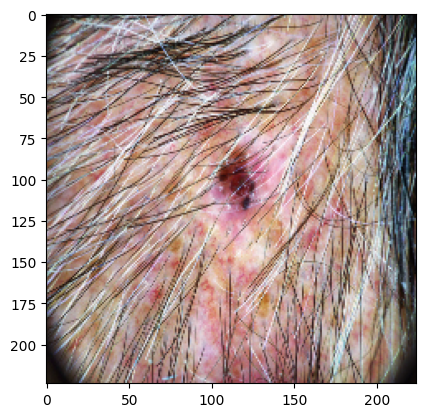

In [24]:
plt.imshow(preprocess_img)

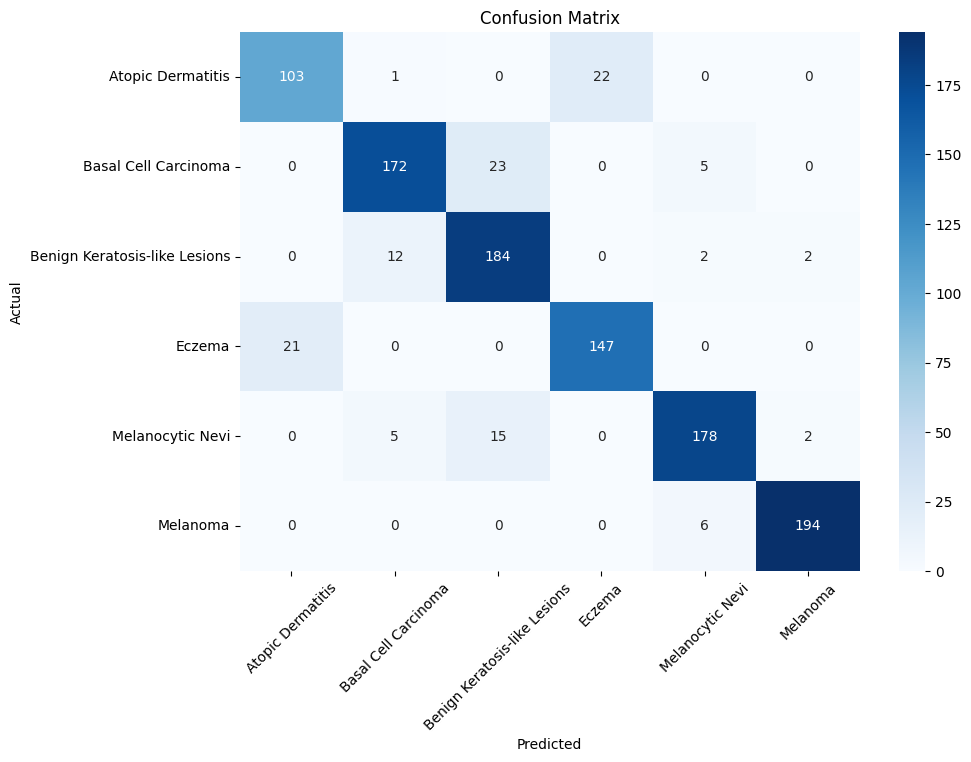

In [25]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set ticks at the center of each class
tick_positions = [i + 0.5 for i in range(len(class_labels))]
plt.xticks(ticks=tick_positions, labels=class_labels, rotation=45)
plt.yticks(ticks=tick_positions, labels=class_labels, rotation=0)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()